In [21]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

In [22]:
def load_yolo_model(cfg_path, weights_path, names_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    with open(names_path, 'r') as f:
        classes = f.read().strip().split('\n')
    return net, classes

# Paths to YOLO files
cfg_path = 'yolov3.cfg'
weights_path = 'yolov3.weights'
names_path = 'coco.names'

# Load YOLO model
yolo_model, classes = load_yolo_model(cfg_path, weights_path, names_path)
print("YOLO model loaded.")

YOLO model loaded.


In [24]:
def detect_objects(net, classes, frame, conf_threshold=0.5, nms_threshold=0.4):
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    detections = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    h, w = frame.shape[:2]

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * w)
                center_y = int(detection[1] * h)
                width = int(detection[2] * w)
                height = int(detection[3] * h)
                x = int(center_x - width / 2)
                y = int(center_y - height / 2)
                boxes.append([x, y, x + width, y + height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    filtered_boxes = []
    if len(indices) > 0:
        for i in indices.flatten():
            box = boxes[i]
            filtered_boxes.append(box + [confidences[i], class_ids[i]])

    return filtered_boxes

In [25]:
class I3DFeatureExtractor(nn.Module):
    def __init__(self):
        super(I3DFeatureExtractor, self).__init__()
        self.i3d = models.video.r3d_18(pretrained=True)
        self.i3d.fc = nn.Identity()  # Remove the classification layer

    def forward(self, x):
        return self.i3d(x)

# Initialize I3D model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
i3d_model = I3DFeatureExtractor().to(device)
i3d_model.eval()
print("I3D model loaded.")

/opt/anaconda3/envs/graphofgraph3.9_new_1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/graphofgraph3.9_new_1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


I3D model loaded.


In [26]:
def process_video(video_path, yolo_model, classes, i3d_model, output_dir, target_fps=20):
    cap = cv2.VideoCapture(video_path)
    frame_features = []
    temporal_edges = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    frame_count = 0
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / target_fps)
    prev_boxes = np.zeros((19, 6))

    while cap.isOpened() and frame_count < 5:
        print("Frame count: ", frame_count)
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            # Extract global features using I3D
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            img_tensor = transform(img).unsqueeze(0).to(device)
            img_tensor = img_tensor.unsqueeze(2).repeat(1, 1, 16, 1, 1)  # Create a fake video clip with 16 frames
            with torch.no_grad():
                feature = i3d_model(img_tensor).cpu().numpy().flatten()
            frame_features.append(feature)

            # Detect objects
            boxes = detect_objects(yolo_model, classes, frame)
            if len(boxes) > 0:
                boxes = np.array(boxes[:19])  # Ensure only 19 boxes are considered
            else:
                boxes = np.zeros((19, 6))  # Initialize with zeros if no boxes detected

            if boxes.shape[0] < 19:
                boxes = np.vstack([boxes, np.zeros((19 - boxes.shape[0], 6))])  # Pad with zeros if less than 19 boxes

            # Calculate temporal edges between objects
            frame_temporal_edges = np.zeros((19, 19))
            for i, box1 in enumerate(prev_boxes):
                for j, box2 in enumerate(boxes):
                    edge = calculate_edge(box1, box2)
                    frame_temporal_edges[i, j] = edge
            temporal_edges.append(frame_temporal_edges)

            prev_boxes = boxes

        frame_count += 1

    cap.release()

    # Ensure we have exactly 50 frames
    while len(frame_features) < 5:
        frame_features.append(np.zeros(2048))
        temporal_edges.append(np.zeros((19, 19)))

    frame_features = np.array(frame_features)
    temporal_edges = np.array(temporal_edges)

    np.save(os.path.join(output_dir, 'frame_features.npy'), frame_features)
    np.save(os.path.join(output_dir, 'temporal_edges.npy'), temporal_edges)
    print("NPY files successfully created.")

def calculate_edge(box1, box2):
    # Calculate the distance between the centers of two bounding boxes
    x1_center = (box1[0] + box1[2]) / 2
    y1_center = (box1[1] + box1[3]) / 2
    x2_center = (box2[0] + box2[2]) / 2
    y2_center = (box2[1] + box2[3]) / 2
    distance = np.sqrt((x1_center - x2_center) ** 2 + (y1_center - y2_center) ** 2)
    return distance

In [27]:
# Directory to save frames with bounding boxes
output_dir = 'output_features'
os.makedirs(output_dir, exist_ok=True)

In [28]:
# Process the video
video_path = './input_clips/positive/clip_0015.mp4'
process_video(video_path, yolo_model, classes, i3d_model, output_dir, target_fps=20)

Frame count:  0
Frame count:  1
Frame count:  2
Frame count:  3
Frame count:  4
NPY files successfully created.


In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Load the npy files
frame_features = np.load('./data/dad/i3d_feat/testing/negative/000839.npy')
# temporal_edges = np.load('output_features/temporal_edges.npy')

# Print the shapes of the arrays
print(f"Shape of frame_features: {frame_features.shape}")
# print(f"Shape of temporal_edges: {temporal_edges.shape}")

Shape of frame_features: (100, 2048)


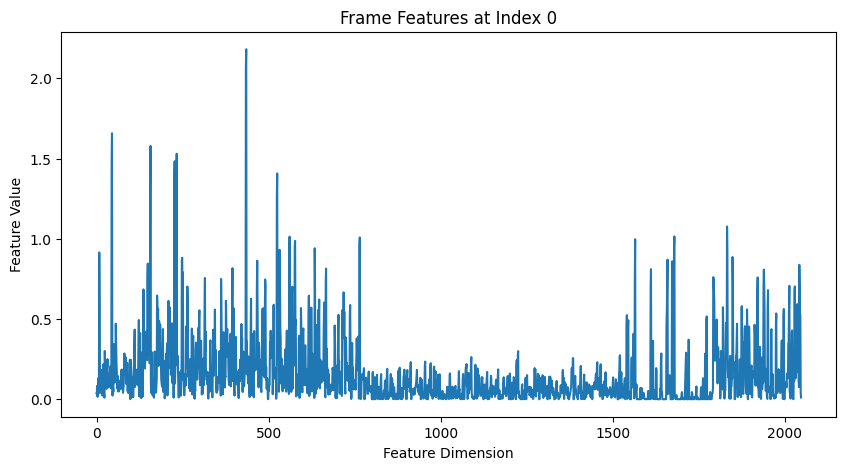

In [20]:
def visualize_frame_features(frame_features, frame_idx):
    plt.figure(figsize=(10, 5))
    plt.plot(frame_features[frame_idx])
    plt.title(f"Frame Features at Index {frame_idx}")
    plt.xlabel("Feature Dimension")
    plt.ylabel("Feature Value")
    plt.show()

# Visualize frame features for a specific frame
visualize_frame_features(frame_features, frame_idx=0)

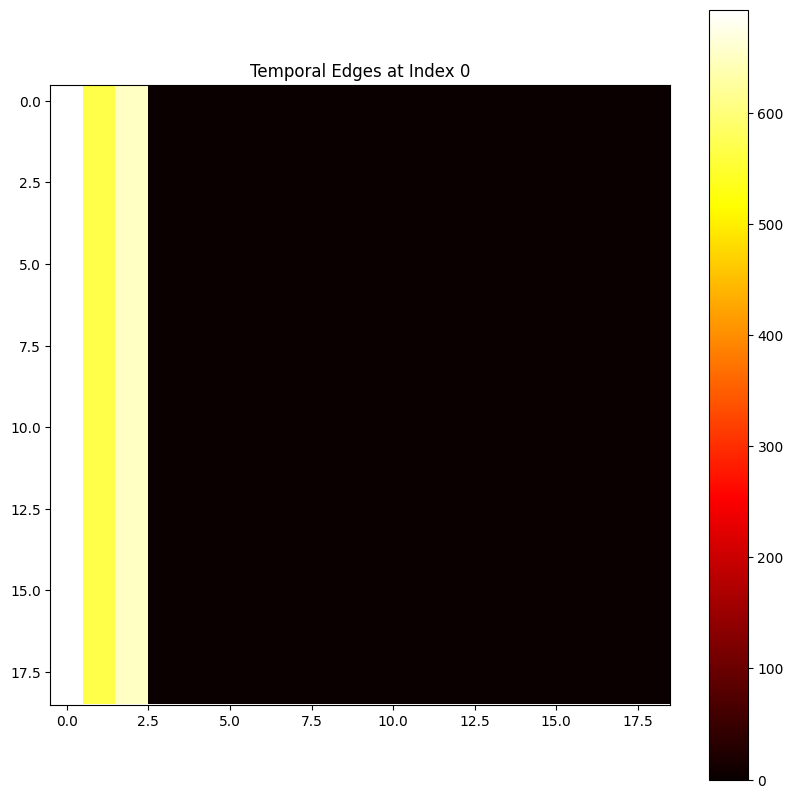

In [18]:
def visualize_temporal_edges(temporal_edges, frame_idx):
    plt.figure(figsize=(10, 10))
    plt.imshow(temporal_edges[frame_idx], cmap='hot', interpolation='nearest')
    plt.title(f"Temporal Edges at Index {frame_idx}")
    plt.colorbar()
    plt.show()

# Visualize temporal edges for a specific frame
visualize_temporal_edges(temporal_edges, frame_idx=0)